In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor

from scipy.stats import pearsonr, spearmanr

import seaborn as sns

from matplotlib import colors

import editdistance

def subselect_list(li, ixs) :
    return [
        li[ixs[k]] for k in range(len(ixs))
    ]

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def dna_letter_at(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange', 
                    'A': 'red', 
                    'C': 'blue', 
                    'T': 'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    return p

def plot_dna_logo(pwm, sequence_template=None, figsize=(12, 3), logo_height=1.0, plot_start=0, plot_end=164, plot_sequence_template=False, save_figs=False, fig_name=None) :

    #Slice according to seq trim index
    pwm = np.copy(pwm[plot_start: plot_end, :])
    sequence_template = sequence_template[plot_start: plot_end]

    pwm += 0.0001
    for j in range(0, pwm.shape[0]) :
        pwm[j, :] /= np.sum(pwm[j, :])

    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(pwm[pwm > 0])
    entropy = np.sum(entropy, axis=1)
    conservation = 2 - entropy

    fig = plt.figure(figsize=figsize)

    ax = plt.gca()

    height_base = (1.0 - logo_height) / 2.

    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, 4) :
            i = sort_index[ii]

            nt_prob = pwm[j, i] * conservation[j]

            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            color = None
            if sequence_template[j] != 'N' :
                color = 'black'
                if plot_sequence_template and nt == sequence_template[j] :
                    nt_prob = 2.0
                else :
                    nt_prob = 0.0

            if ii == 0 :
                dna_letter_at(nt, j + 0.5, height_base, nt_prob * logo_height, ax, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                dna_letter_at(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax, color=color)

    plt.xlim((0, plot_end - plot_start))
    plt.ylim((0, 2))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    plt.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)

    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    plt.show()

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax)

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)

    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    plt.tight_layout()
    
    plt.show()

def plot_importance_scores_with_neg(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01
    min_score = np.min(np.sum(importance_scores[:, :], axis=0)) - 0.01
    
    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        if mutability_score >= 0.0 :
            dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax)
        else :
            dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax)

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((min_score, max_score))
    plt.axis('off')
    plt.yticks([min_score, max_score], [min_score, max_score], fontsize=16)

    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    plt.tight_layout()
    
    plt.show()


Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
#Get and filter dataset

df = pd.read_csv('../GSM3130435_egfp_unmod_1.csv')

df = df.loc[~df['utr'].str.contains('ATG')].copy().reset_index(drop=True)
df = df.loc[df['utr'].str.slice(0, 2) != 'TG'].copy().reset_index(drop=True)

df = df.query("total_reads >= 250").copy().reset_index(drop=True)

shuffle_index = np.arange(len(df))
np.random.shuffle(shuffle_index)

df = df.iloc[shuffle_index].copy().reset_index(drop=True)

print("len(df) = " + str(len(df)))


len(df) = 125931


In [7]:
#Partition into train and test splits

n_train = 100000
n_test = len(df) - n_train

df_train = df.iloc[:n_train].copy().reset_index(drop=True)
df_test = df.iloc[n_train:].copy().reset_index(drop=True)

print("len(df_train) = " + str(len(df_train)))
print("len(df_test) = " + str(len(df_test)))


len(df_train) = 100000
len(df_test) = 25931


In [2]:
#Reconstruct sequences from pre-computed one-hot-coded matrices

use_cached_version = True

sequence_encoder = IdentityEncoder(50, {'A':0, 'C':1, 'G':2, 'T':3})

seqs_train = None
seqs_test = None

y_train = None
y_test = None

if use_cached_version :
    seqs_train = pd.read_csv("optimus5_seqs_no_atg_train.csv", sep="\t")["seq"].values.tolist()
    seqs_test = pd.read_csv("optimus5_seqs_no_atg_test.csv", sep="\t")["seq"].values.tolist()
    y_train = np.array(pd.read_csv("optimus5_seqs_no_atg_train.csv", sep="\t")["mrl"].values)
    y_test = np.array(pd.read_csv("optimus5_seqs_no_atg_test.csv", sep="\t")["mrl"].values)
else :
    seqs_train = df_train['utr'].values.tolist()
    seqs_test = df_test['utr'].values.tolist()
    
    y_train = np.array(df_train["rl"].values)
    y_test = np.array(df_test["rl"].values)

    seqs_train_df = pd.DataFrame({'seq' : seqs_train, 'mrl' : y_train})
    seqs_train_df.to_csv("optimus5_seqs_no_atg_train.csv", sep="\t", index=False)

    seqs_test_df = pd.DataFrame({'seq' : seqs_test, 'mrl' : y_test})
    seqs_test_df.to_csv("optimus5_seqs_no_atg_test.csv", sep="\t", index=False)

print("len(seqs_train) = " + str(len(seqs_train)))
print("len(seqs_test) = " + str(len(seqs_test)))

print("y_train.shape = " + str(y_train.shape))
print("y_test.shape = " + str(y_test.shape))


len(seqs_train) = 100000
len(seqs_test) = 25931
y_train.shape = (100000,)
y_test.shape = (25931,)


In [3]:
#Compute k-mer count matrices

use_cached_version = True

sparse_mer2_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=2, count_n_mers=True))
sparse_mer3_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=3, count_n_mers=True))
sparse_mer4_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=4, count_n_mers=True))
sparse_mer5_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=5, count_n_mers=True))
sparse_mer6_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=6, count_n_mers=True))

mer2_train = None
mer3_train = None
mer4_train = None
mer5_train = None
mer6_train = None

mer2_test = None
mer3_test = None
mer4_test = None
mer5_test = None
mer6_test = None

if use_cached_version :
    mer2_train = spio.loadmat("optimus5_no_atg_mer2_counts_train.mat")["mer2_train"]
    mer3_train = spio.loadmat("optimus5_no_atg_mer3_counts_train.mat")["mer3_train"]
    mer4_train = spio.loadmat("optimus5_no_atg_mer4_counts_train.mat")["mer4_train"]
    mer5_train = spio.loadmat("optimus5_no_atg_mer5_counts_train.mat")["mer5_train"]
    mer6_train = spio.loadmat("optimus5_no_atg_mer6_counts_train.mat")["mer6_train"]

    mer2_test = spio.loadmat("optimus5_no_atg_mer2_counts_test.mat")["mer2_test"]
    mer3_test = spio.loadmat("optimus5_no_atg_mer3_counts_test.mat")["mer3_test"]
    mer4_test = spio.loadmat("optimus5_no_atg_mer4_counts_test.mat")["mer4_test"]
    mer5_test = spio.loadmat("optimus5_no_atg_mer5_counts_test.mat")["mer5_test"]
    mer6_test = spio.loadmat("optimus5_no_atg_mer6_counts_test.mat")["mer6_test"]
else :
    mer2_train = sparse_mer2_encoder(seqs_train)
    mer3_train = sparse_mer3_encoder(seqs_train)
    mer4_train = sparse_mer4_encoder(seqs_train)
    mer5_train = sparse_mer5_encoder(seqs_train)
    mer6_train = sparse_mer6_encoder(seqs_train)
    
    mer2_test = sparse_mer2_encoder(seqs_test)
    mer3_test = sparse_mer3_encoder(seqs_test)
    mer4_test = sparse_mer4_encoder(seqs_test)
    mer5_test = sparse_mer5_encoder(seqs_test)
    mer6_test = sparse_mer6_encoder(seqs_test)
    
    spio.savemat("optimus5_no_atg_mer2_counts_train.mat", {"mer2_train" : mer2_train})
    spio.savemat("optimus5_no_atg_mer3_counts_train.mat", {"mer3_train" : mer3_train})
    spio.savemat("optimus5_no_atg_mer4_counts_train.mat", {"mer4_train" : mer4_train})
    spio.savemat("optimus5_no_atg_mer5_counts_train.mat", {"mer5_train" : mer5_train})
    spio.savemat("optimus5_no_atg_mer6_counts_train.mat", {"mer6_train" : mer6_train})

    spio.savemat("optimus5_no_atg_mer2_counts_test.mat", {"mer2_test" : mer2_test})
    spio.savemat("optimus5_no_atg_mer3_counts_test.mat", {"mer3_test" : mer3_test})
    spio.savemat("optimus5_no_atg_mer4_counts_test.mat", {"mer4_test" : mer4_test})
    spio.savemat("optimus5_no_atg_mer5_counts_test.mat", {"mer5_test" : mer5_test})
    spio.savemat("optimus5_no_atg_mer6_counts_test.mat", {"mer6_test" : mer6_test})

print("mer6_train.shape = " + str(mer6_train.shape))
print("mer6_test.shape = " + str(mer6_test.shape))


mer6_train.shape = (100000, 4096)
mer6_test.shape = (25931, 4096)


In [4]:
#Create concatenated (log) feature data matrix

mer_train = sp.csr_matrix(sp.hstack([
    mer2_train,
    mer3_train,
    mer4_train,
    mer5_train,
    mer6_train
]))

mer_test = sp.csr_matrix(sp.hstack([
    mer2_test,
    mer3_test,
    mer4_test,
    mer5_test,
    mer6_test
]))


log_mer_train = sp.coo_matrix(mer_train.copy())
log_mer_train.data = np.log2(1. + log_mer_train.data)
log_mer_train = sp.csr_matrix(log_mer_train)

log_mer_test = sp.coo_matrix(mer_test.copy())
log_mer_test.data = np.log2(1. + log_mer_test.data)
log_mer_test = sp.csr_matrix(log_mer_test)

print("log_mer_train.shape = " + str(log_mer_train.shape))
print("log_mer_test.shape = " + str(log_mer_test.shape))


log_mer_train.shape = (100000, 5456)
log_mer_test.shape = (25931, 5456)


In [5]:
#Train a sparse k-mer lasso model (k-mer feature selection step)

use_cached_version = True

n_train_subset = 50000
l1_alpha = 0.001

if use_cached_version :
    mer_lasso = pickle.load(open("optimus5_mer23456_no_atg_lasso_l1_alpha_" + str(l1_alpha).replace(".", "_") + "_n_train_" + str(n_train_subset) + ".pickle", "rb"))["mer6_lasso"]
else :
    shuffle_index = np.arange(log_mer_train.shape[0])
    np.random.shuffle(shuffle_index)

    mer_lasso = linear_model.Lasso(alpha=l1_alpha).fit(log_mer_train[shuffle_index[:n_train_subset]], y_train[shuffle_index[:n_train_subset]])
    
    pickle.dump({
        "mer6_lasso" : mer_lasso,
        "mer6_lasso.intercept_" : mer_lasso.intercept_,
        "mer6_lasso.coef_" : mer_lasso.coef_
    }, open("optimus5_mer23456_no_atg_lasso_l1_alpha_" + str(l1_alpha).replace(".", "_") + "_n_train_" + str(n_train_subset) + ".pickle", "wb"))

print("# nonzero coefficients (lasso) = " + str(len(mer_lasso.coef_[mer_lasso.coef_ != 0.])))


# nonzero coefficients (lasso) = 272


In [6]:
#Train an L2-regularized linear model using features discovered earlier (de-biasing step)

use_cached_version = True

l2_alpha = 0.0

nonzero_feat_ix = np.nonzero(mer_lasso.coef_)[0]

if use_cached_version :
    mer_linear = pickle.load(open("optimus5_mer23456_no_atg_linear_l2_alpha_" + str(l2_alpha).replace(".", "_") + ".pickle", "rb"))["mer6_linear"]
else :
    mer_linear = linear_model.Ridge(alpha=l2_alpha).fit(log_mer_train[:, nonzero_feat_ix], y_train[:])
    
    pickle.dump({
        "mer6_linear" : mer_linear,
        "nonzero_feat_ix" : nonzero_feat_ix,
        "mer6_linear.intercept_" : mer_linear.intercept_,
        "mer6_linear.coef_" : mer_linear.coef_
    }, open("optimus5_mer23456_no_atg_linear_l2_alpha_" + str(l2_alpha).replace(".", "_") + ".pickle", "wb"))

print("# nonzero coeffs = " + str(len(mer_linear.coef_[mer_linear.coef_ != 0.])))


# nonzero coeffs = 272


-- K-mer Linear Model (Training data) --
pearson-r correlation = 0.5217
pearson-r p = 0.0


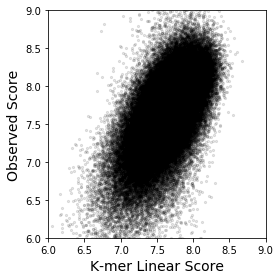

-- K-mer Linear Model (Test data) --
pearson-r correlation = 0.5213
pearson-r p = 0.0


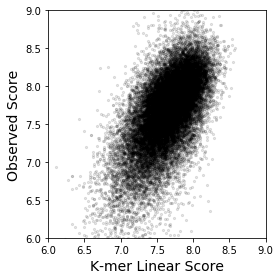

In [7]:
#Predict on data using linear k-mer model

print("-- K-mer Linear Model (Training data) --")

y_train_hat = mer_linear.predict(log_mer_train[:, nonzero_feat_ix])

print("pearson-r correlation = " + str(round(pearsonr(y_train_hat, y_train)[0], 4)))
print("pearson-r p = " + str(round(pearsonr(y_train_hat, y_train)[1], 4)))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_train_hat, y_train, s=5, color='black', alpha=0.1)

plt.xlim(6, 9)
plt.ylim(6, 9)

plt.xlabel("K-mer Linear Score", fontsize=14)
plt.ylabel("Observed Score", fontsize=14)

plt.tight_layout()
plt.show()

print("-- K-mer Linear Model (Test data) --")

y_test_hat = mer_linear.predict(log_mer_test[:, nonzero_feat_ix])

print("pearson-r correlation = " + str(round(pearsonr(y_test_hat, y_test)[0], 4)))
print("pearson-r p = " + str(round(pearsonr(y_train_hat, y_train)[1], 4)))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_test_hat, y_test, s=5, color='black', alpha=0.1)

plt.xlim(6, 9)
plt.ylim(6, 9)

plt.xlabel("K-mer Linear Score", fontsize=14)
plt.ylabel("Observed Score", fontsize=14)

plt.tight_layout()
plt.show()


In [ ]:
#Print feature weights

#2-mer features
sparse_index = np.nonzero(nonzero_feat_ix < 16)[0]
feature_index = nonzero_feat_ix[nonzero_feat_ix < 16]
_enc = sparse_mer2_encoder

for i, sparse_ix in enumerate(sparse_index) :
    print(str(sparse_ix) + ": " + _enc.encoder.decode_map[feature_index[i]] + " = " + str(round(mer_linear.coef_[sparse_ix], 2)))

#3-mer features
sparse_index = np.nonzero((nonzero_feat_ix >= 16) & (nonzero_feat_ix < 16 + 64))[0]
feature_index = nonzero_feat_ix[(nonzero_feat_ix >= 16) & (nonzero_feat_ix < 16 + 64)]
_enc = sparse_mer3_encoder

for i, sparse_ix in enumerate(sparse_index) :
    print(str(sparse_ix) + ": " + _enc.encoder.decode_map[feature_index[i] - 16] + " = " + str(round(mer_linear.coef_[sparse_ix], 2)))

#4-mer features
sparse_index = np.nonzero((nonzero_feat_ix >= 16 + 64) & (nonzero_feat_ix < 16 + 64 + 256))[0]
feature_index = nonzero_feat_ix[(nonzero_feat_ix >= 16 + 64) & (nonzero_feat_ix < 16 + 64 + 256)]
_enc = sparse_mer4_encoder

for i, sparse_ix in enumerate(sparse_index) :
    print(str(sparse_ix) + ": " + _enc.encoder.decode_map[feature_index[i] - 16 - 64] + " = " + str(round(mer_linear.coef_[sparse_ix], 2)))

#5-mer features
sparse_index = np.nonzero((nonzero_feat_ix >= 16 + 64 + 256) & (nonzero_feat_ix < 16 + 64 + 256 + 1024))[0]
feature_index = nonzero_feat_ix[(nonzero_feat_ix >= 16 + 64 + 256) & (nonzero_feat_ix < 16 + 64 + 256 + 1024)]
_enc = sparse_mer5_encoder

for i, sparse_ix in enumerate(sparse_index) :
    print(str(sparse_ix) + ": " + _enc.encoder.decode_map[feature_index[i] - 16 - 64 - 256] + " = " + str(round(mer_linear.coef_[sparse_ix], 2)))

#6-mer features
sparse_index = np.nonzero((nonzero_feat_ix >= 16 + 64 + 256 + 1024) & (nonzero_feat_ix < 16 + 64 + 256 + 1024 + 4096))[0]
feature_index = nonzero_feat_ix[(nonzero_feat_ix >= 16 + 64 + 256 + 1024) & (nonzero_feat_ix < 16 + 64 + 256 + 1024 + 4096)]
_enc = sparse_mer6_encoder

for i, sparse_ix in enumerate(sparse_index) :
    print(str(sparse_ix) + ": " + _enc.encoder.decode_map[feature_index[i] - 16 - 64 - 256 - 1024] + " = " + str(round(mer_linear.coef_[sparse_ix], 2)))


In [9]:
#Load k-mer model

def get_linear_predict_func() :
    
    sparse_mer2_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=2, count_n_mers=True))
    sparse_mer3_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=3, count_n_mers=True))
    sparse_mer4_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=4, count_n_mers=True))
    sparse_mer5_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=5, count_n_mers=True))
    sparse_mer6_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=6, count_n_mers=True))
    
    onehot_encoder = isol.OneHotEncoder(50)
    
    l2_alpha = 0.0
    
    nonzero_feat_ix = pickle.load(open("optimus5_mer23456_no_atg_linear_l2_alpha_" + str(l2_alpha).replace(".", "_") + ".pickle", "rb"))["nonzero_feat_ix"]
    linear_model = pickle.load(open("optimus5_mer23456_no_atg_linear_l2_alpha_" + str(l2_alpha).replace(".", "_") + ".pickle", "rb"))["mer6_linear"]
    
    def _predict_func(seqs, linear_model=linear_model, nonzero_feat_ix=nonzero_feat_ix) :
        
        mer2 = sparse_mer2_encoder(seqs)
        mer3 = sparse_mer3_encoder(seqs)
        mer4 = sparse_mer4_encoder(seqs)
        mer5 = sparse_mer5_encoder(seqs)
        mer6 = sparse_mer6_encoder(seqs)

        mer = sp.csr_matrix(sp.hstack([
            mer2,
            mer3,
            mer4,
            mer5,
            mer6
        ]))

        log_mer = sp.coo_matrix(mer.copy())
        log_mer.data = np.log2(1. + log_mer.data)
        log_mer = sp.csr_matrix(log_mer)
        
        gt_score = linear_model.predict(log_mer[:, nonzero_feat_ix])
        
        onehots = []
        sequence_scores = []
        score_mats = []
        for i in range(len(seqs)) :
            seq = seqs[i]
            sequence_score = np.zeros(len(seq))
            score_mat = np.zeros((len(seq), nonzero_feat_ix.shape[0]))
            
            Ks = [2, 3, 4, 5, 6]
            _encs = [
                sparse_mer2_encoder.encoder,
                sparse_mer3_encoder.encoder,
                sparse_mer4_encoder.encoder,
                sparse_mer5_encoder.encoder,
                sparse_mer6_encoder.encoder
            ]
            n_prevs = [0, 16, 16 + 64, 16 + 64 + 256, 16 + 64 + 256 + 1024]
            for K, _enc, n_prev in zip(Ks, _encs, n_prevs) :
                for j in range(len(seq) - K + 1) :
                    curr_mer = seq[j:j+K]
                    feature_ix = _enc.encode_map[curr_mer] + n_prev

                    if feature_ix in nonzero_feat_ix :
                        sparse_ix = np.nonzero(nonzero_feat_ix == feature_ix)[0][0]
                        sequence_score[j:j+K] += linear_model.coef_[sparse_ix]
                        
                        score_mat[j:j+K, sparse_ix] += 1.
            
            onehot = onehot_encoder(seq)
            sequence_score = np.expand_dims(sequence_score, axis=-1) * onehot
            
            onehots.append(onehot)
            sequence_scores.append(sequence_score)
            score_mats.append(score_mat)
        
        return gt_score, onehots, sequence_scores, score_mats
    
    return _predict_func

k_mer_model = get_linear_predict_func()


In [10]:
#Load retranined Optimus 5' MRL model

def get_optimus5_retrained_main_predict_func() :
    
    #Specfiy file path to pre-trained predictor network

    onehot_encoder = isol.OneHotEncoder(50)
    
    model_path = os.path.join('../retrained_main_MRL_model.hdf5')
    optimus5 = load_model(model_path)
    
    def _predict_func(seqs, optimus5=optimus5, allow_atg=False) :
        
        onehots = np.concatenate([np.expand_dims(onehot_encoder(seq), axis=0) for seq in seqs], axis=0)
        
        gt_score = optimus5.predict(x=[onehots[:, :50, :]])[:, 0]
        
        sequence_scores = np.zeros((onehots.shape[0], 50, 4))
        for data_ix in range(onehots.shape[0]) :
            x = onehots[data_ix, :, :]
            x_var = np.zeros((x.shape[0] * x.shape[1], x.shape[0], x.shape[1]))

            x_var[:, :, :] = x[:, :]

            for j in range(x_var.shape[1]) :
                for k in range(x_var.shape[2]) :
                    x_var[j * x_var.shape[2] + k, j, :] = 0.
                    x_var[j * x_var.shape[2] + k, j, k] = 1.

            gt_score_var = optimus5.predict([x_var[:, :50, :]], batch_size=32)[:, 0]

            for j in range(x_var.shape[1]) :
                for k in range(x_var.shape[2]) :
                    if allow_atg or ('ATG' not in onehot_encoder.decode(x_var[j * x_var.shape[2] + k])) :
                        sequence_scores[data_ix, j, k] = gt_score_var[j * x_var.shape[2] + k] - gt_score[data_ix]
            
            sequence_scores[data_ix, ...] = np.tile(np.expand_dims(np.mean(sequence_scores[data_ix, ...], axis=-1), axis=-1), (1, 4))
            sequence_scores[data_ix, ...] = -1 * sequence_scores[data_ix, ...] * onehots[data_ix, ...]
            
        onehots = [onehots[i, :, :] for i in range(onehots.shape[0])]
        sequence_scores = [sequence_scores[i, :, :] for i in range(sequence_scores.shape[0])]
        
        return gt_score.tolist(), onehots, sequence_scores
    
    return _predict_func

optimus5 = get_optimus5_retrained_main_predict_func()


Model prediction = 8.2147 (qt = 0.98)
Min Score = -0.0435, Max Score = 0.2697


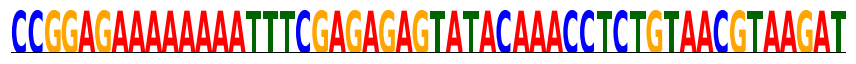

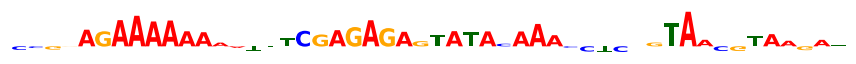

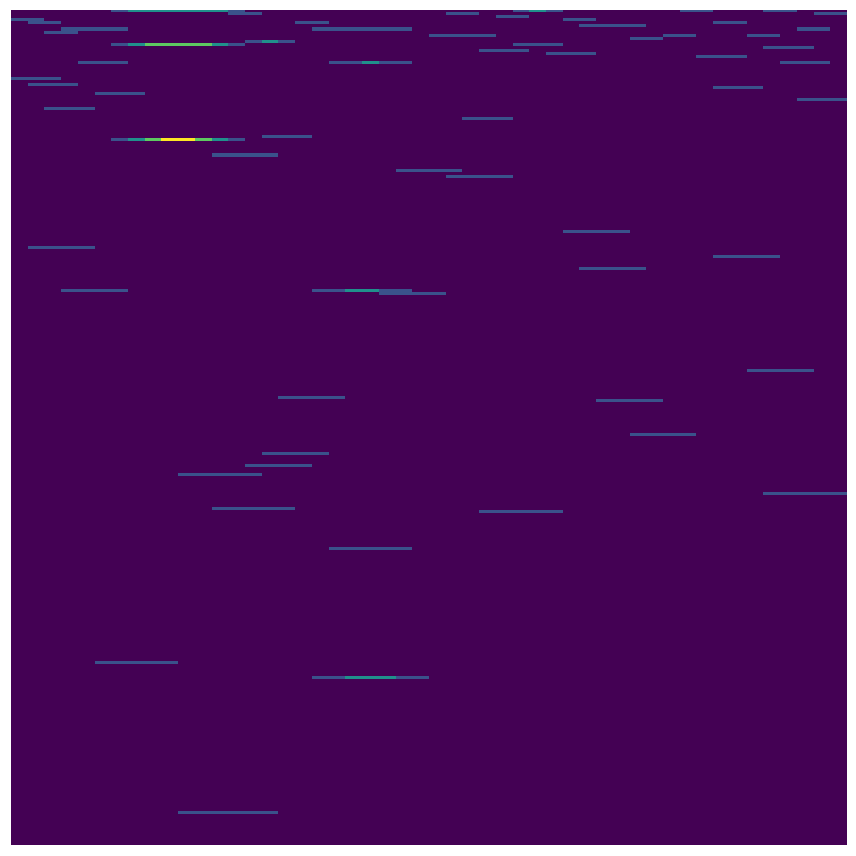

In [20]:
#Explain sequence with linear k-mer model

test_seq = "CCGGAGAAAAAAAATTTCGAGAGAGTATACAAACCTCTGTAACGTAAGAT"

y_pred, onehot, importance_scores, score_mat = k_mer_model([test_seq])
y_pred, onehot, importance_scores, score_mat = y_pred[0], onehot[0], importance_scores[0], score_mat[0]

qt = 1. - np.sum(y_test_hat > y_pred) / y_test_hat.shape[0]

print("Model prediction = " + str(round(y_pred, 4)) + " (qt = " + str(round(qt, 2)) + ")")
print("Min Score = " + str(round(np.min(importance_scores), 4)) + ", Max Score = "  + str(round(np.max(importance_scores), 4)))

score_clip = None

plot_dna_logo(onehot, sequence_template='N'*50, figsize=(12, 1), logo_height=1.0, plot_start=0, plot_end=50)
plot_importance_scores_with_neg(importance_scores.T, test_seq, figsize=(12, 1), score_clip=score_clip, plot_start=0, plot_end=50)

f = plt.figure(figsize=(12, 12))

plt.imshow(score_mat.T, aspect='auto')

plt.xticks([], [])
plt.yticks([], [])
plt.axis('off')

for axis in f.axes :
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)

plt.tight_layout()

plt.show()


Model prediction = 1.0372
Min Score = -0.0129, Max Score = 0.1524


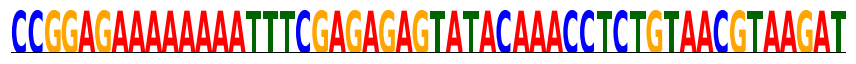

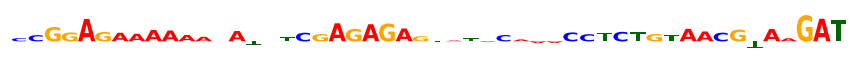

In [21]:
#Explain sequence with optimus 5 model

test_seq = "CCGGAGAAAAAAAATTTCGAGAGAGTATACAAACCTCTGTAACGTAAGAT"

y_pred, onehot, importance_scores = optimus5([test_seq])
y_pred, onehot, importance_scores = y_pred[0], onehot[0], importance_scores[0]

print("Model prediction = " + str(round(y_pred, 4)))
print("Min Score = " + str(round(np.min(importance_scores), 4)) + ", Max Score = "  + str(round(np.max(importance_scores), 4)))

score_clip = 0.05

plot_dna_logo(onehot, sequence_template='N'*50, figsize=(12, 1), logo_height=1.0, plot_start=0, plot_end=50)
plot_importance_scores_with_neg(importance_scores.T, test_seq, figsize=(12, 1), score_clip=score_clip, plot_start=0, plot_end=50)
